# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington D.C. is one of those cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The dataset we will be working with was compiled by Hadi Fanaee-T at the University of Porto. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

In this project, we will try to predict the total number of bikes people rented in a given hour. In the dataset, the value we are predicting is the 'cnt' column and we will use all columns except for 'casual' and 'registered'. To accomplish this, we will create a few different machine learning models and evaluate their performance.

Let's start by investigating the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


There are no null values, but we will need to convert some columns to the right data type, such as dteday. Before we start cleaning the data, lets examine the distribution of the data.

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

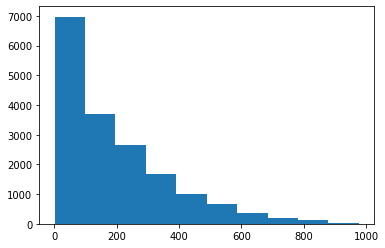

In [3]:
plt.hist(bike_rentals['cnt'])

Most hours have between 0-200 rentals per hour. The distribution is heavily right-skewed. Next, lets examine how each column correlates with cnt

In [4]:
abs(bike_rentals.corr()['cnt']).sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Temperature, time of day, and humidity are most strongly correlated with number of rides per hour.

## Feature Engineering

It can be helpful to calculate new features to introduce new information or to distill existing information.

The hr column contains the hours during which bikes were rented, from 1 to 24. A machine will treat each hour differently, without understanding that some hours are related. Lets create labels for the time of day (morning, afternoon, evening, night) to bundle similar times together, allowing the model to make better decisions.

In [5]:
def assign_label(hour):
    if hour < 6:
        return 4
    elif hour < 12:
        return 1
    elif hour < 18:
        return 2
    else:
        return 3

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

bike_rentals
    
    

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,3
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,3
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,3
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,3


## Preparing Train and Test Data

We will need to split the data into a training dataset that we will train our algorithm with and a test dataset to evaluate our model. We will select 80% of our dataset for our training dataset and the rest for testing.

The mean squared error metric makes the most sense to evaluate our model error. MSE works on continuous numeric data, which fits our data quite well since we are looking to predict the number of bikes rented in an hour, and not a categorical value.

In [6]:
train = bike_rentals.sample(frac = .8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

Now that we have our train and test data, we are ready to apply machine learning models on our data.

## Linear Regression Model

Linear regression will likely work fairly well on the data, given that many of the columns are highly correlated with cnt.
We will need to ignore the casual and registered columns because cnt is derived from them. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
            'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
            'time_label']

lr = LinearRegression()
lr.fit(train[features],train['cnt'])
lr_predictions = lr.predict(test[features])

lr_mse = mean_squared_error(test['cnt'],lr_predictions)
lr_rmse = lr_mse**0.5
print("MSE: ",lr_mse,'\nRMSE: ',lr_rmse)

MSE:  17251.40179481665 
RMSE:  131.3445917988885


The mean squared error is very high. This is likely because our data has few extremely high rental counts, but mainly low counts. Large errors are penalized more with MSE, lreading to higher total error. 

Linear Regression is fairly resistant to overfitting the data because it is straightforward. It can also be prone to underfitting the data and not building a powerful enough model however. This means linear regression usually isnt the most accurate option.

## Decision Tree Algorithm

Let's now run a decision tree algorithm on our dataset and compare its error with linear regression.

Decision trees tend to predict outcomes much more reliably than linear regression models. But because it is a fairly complex mode, it tends to overfit the dataset, expecially when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Let's keep this in mind when building our decision tree model.

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(train[features],train['cnt'])
tree_predictions = tree.predict(test[features])
tree_mse = mean_squared_error(test['cnt'],tree_predictions)

print("Linear Regression MSE: ",lr_mse,'\nDecision Tree MSE: ',tree_mse)

Linear Regression MSE:  17251.40179481665 
Decision Tree MSE:  3601.053006329114


The decision tree model significantly reduced our mean squared error! Let's continue to tweak some parameters of the DecisionTreeRegressor class to see if it improves our error value

In [9]:
tree1 = DecisionTreeRegressor(min_samples_leaf = 5)

tree1.fit(train[features],train['cnt'])
tree1_predictions = tree1.predict(test[features])
tree1_mse = mean_squared_error(test['cnt'],tree1_predictions)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',
      tree_mse,'\nDecision Tree (min_samples_leaf = 5): ',tree1_mse)

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5):  2767.3647852621157


In [10]:
tree2 = DecisionTreeRegressor(min_samples_leaf = 10)

tree2.fit(train[features],train['cnt'])
tree2_predictions = tree2.predict(test[features])
tree2_mse = mean_squared_error(test['cnt'],tree2_predictions)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5): ',tree1_mse,
      '\nDecision Tree (min_samples_leaf = 10): ',tree2_mse)

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5):  2767.3647852621157 
Decision Tree (min_samples_leaf = 10):  2785.745026001085


Requiring 5 samples to be at a leaf node further improved results drastically. However, when we increased this value to 10, our error got worse. Let's stick to a value of 5 for this parameter. 

Let's experiment with the max_depth parameter as well

In [11]:
tree3 = DecisionTreeRegressor(min_samples_leaf = 5,max_depth = 8)

tree3.fit(train[features],train['cnt'])
tree3_predictions = tree3.predict(test[features])
tree3_mse = mean_squared_error(test['cnt'],tree3_predictions)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5): ',tree1_mse,
      '\nDecision Tree (min_samples_leaf = 10): ',tree2_mse,
      '\nDecision Tree (min_samples_leaf = 5,max_depth = 8): ',tree3_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5):  2767.3647852621157 
Decision Tree (min_samples_leaf = 10):  2785.745026001085 
Decision Tree (min_samples_leaf = 5,max_depth = 8):  5470.743332188596


Setting a limit on max_depth increases our error, but it can help ensure our model isn't overfitted. However, considering the MSE was almost doubled when imposing a limit on depth, we wont include this parameter in our model.

It appears the decision tree regressor has much higher accuracy than linear regression.

## Random Forest Algorithm

Now that we have built a linear regression model and decision tree model, let's apply the random forest algorithm, which improves on the decision tree algorithm. 

Random forests tend to be much more accurate than simple models like linear regression, and tend to overfit much less than decision trees. Random forests can still be prone to overfitting however, so it is important to continue tuning parameters like minimum samples per leaf and maximum depth

In [12]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(train[features],train['cnt'])
forest_prediction = forest.predict(test[features])

forest_mse = mean_squared_error(test['cnt'],forest_prediction)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samp_leaf = 5) MSE: ',tree1_mse,
      '\nSimple Random Forest MSE: ',forest_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samp_leaf = 5) MSE:  2767.3647852621157 
Simple Random Forest MSE:  1945.104269434855


A Simple Random Forest has drastically approved our error value again, now below 2000. Let's experiment with various parameters of the RandomForestRegressor class to continue to minimize the error

In [13]:
forest1 = RandomForestRegressor(min_samples_leaf = 3)
forest1.fit(train[features],train['cnt'])
forest1_prediction = forest1.predict(test[features])

forest1_mse = mean_squared_error(test['cnt'],forest1_prediction)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5) MSE: ',tree1_mse,
      '\nSimple Random Forest MSE: ',forest_mse,
      '\nRandom Forest (min_samples_leaf = 3) MSE: ',forest1_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5) MSE:  2767.3647852621157 
Simple Random Forest MSE:  1945.104269434855 
Random Forest (min_samples_leaf = 3) MSE:  1953.6200300003507


In [14]:
forest2 = RandomForestRegressor(max_depth = 7)
forest2.fit(train[features],train['cnt'])
forest2_prediction = forest2.predict(test[features])

forest2_mse = mean_squared_error(test['cnt'],forest2_prediction)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5) MSE: ',tree1_mse,
      '\nSimple Random Forest MSE: ',forest_mse,
      '\nRandom Forest (min_samples_leaf = 3) MSE: ',forest1_mse,
      '\nRandom Forest (max_depth = 7) MSE: ',forest2_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5) MSE:  2767.3647852621157 
Simple Random Forest MSE:  1945.104269434855 
Random Forest (min_samples_leaf = 3) MSE:  1953.6200300003507 
Random Forest (max_depth = 7) MSE:  6023.994074297851


In [15]:
forest3 = RandomForestRegressor(n_estimators = 50,min_samples_leaf = 3)
forest3.fit(train[features],train['cnt'])
forest3_prediction = forest3.predict(test[features])

forest3_mse = mean_squared_error(test['cnt'],forest3_prediction)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5) MSE: ',tree1_mse,
      '\nSimple Random Forest MSE: ',forest_mse,
      '\nRandom Forest (min_samples_leaf = 3) MSE: ',forest1_mse,
      '\nRandom Forest (max_depth = 7) MSE: ',forest2_mse,
      '\nRandom Forest (n_estimators = 50, min_samples_leaf = 3) MSE: ', forest3_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5) MSE:  2767.3647852621157 
Simple Random Forest MSE:  1945.104269434855 
Random Forest (min_samples_leaf = 3) MSE:  1953.6200300003507 
Random Forest (max_depth = 7) MSE:  6023.994074297851 
Random Forest (n_estimators = 50, min_samples_leaf = 3) MSE:  1833.329359076082


Similar to the decision tree, the random forest was further improved by changing the min_samples_leaf parameter. This time, a value of 3 produced the best results. Max Depth again significantly worsened our error, so we will not use this parameter going forward.

We also explored the n_estimators parameter, which determines how many trees we have in our forest. This parameter did reduce the error, but at the cost of compute time. It did not create a significant enough of an impact on our error to have 50 trees in our forest.

## Conclusion and Next Steps

In this project we applied several machine learning models on the D.C. bike rentals dataset to predict how many bikes are rented each hour. 

First we explored a simple model, linear regression. This model performed the worst, likely because it underfit the data. 

We then turned to a decision tree model, which significantly reduced the error in our model. We found it was important to limit the complexity of the model to prevent overfitting.

Finally, we explored a random forest model, which is typically more accurate than linear regression models and tend to overfit less compared to decision trees. We found this model produced the lowest error.

To further improve our model, we can continue practice feature engineering to create new columns in our dataset. For example, we can create an index combining temperature, humidity, and wind speed to further describe the type of day it was. We can also try predicting casual and registered instead of cnt.

### Creating a Heat Index Column

Conceptually, hotter temperatures, higher winds, and higher humidity all create a less pleasant riding experience. Considering their significance moves in similar directions (riding conditions get worse the higher any of these get) and they are all normalized, we can likely sum them all together to get a general weather index. Let's try applying this to our model.

In [16]:
bike_rentals['thw_index'] = bike_rentals['atemp'] + bike_rentals['hum'] + bike_rentals['windspeed']

train = bike_rentals.sample(frac = .8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

features = features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
            'workingday', 'weathersit','temp','atemp','hum','windspeed', 'thw_index',
            'time_label']

forest_thw = RandomForestRegressor(min_samples_leaf = 3)
forest_thw.fit(train[features],train['cnt'])
forest_thw_prediction = forest_thw.predict(test[features])

forest_thw_mse = mean_squared_error(test['cnt'],forest_thw_prediction)

print("Linear Regression MSE: ",lr_mse,
      '\nSimple Decision Tree MSE: ',tree_mse,
      '\nDecision Tree (min_samples_leaf = 5) MSE: ',tree1_mse,
      '\nSimple Random Forest MSE: ',forest_mse,
      '\nRandom Forest THW Index(min_samples_leaf = 3) MSE: ',forest_thw_mse
     )

Linear Regression MSE:  17251.40179481665 
Simple Decision Tree MSE:  3601.053006329114 
Decision Tree (min_samples_leaf = 5) MSE:  2767.3647852621157 
Simple Random Forest MSE:  1945.104269434855 
Random Forest THW Index(min_samples_leaf = 3) MSE:  1970.5022319799302


Adding this feature did not improve our error. We could likely create a THW index if we did not have normalized values to apply a Heat Index + Wind Index formula.

In [17]:
features = features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
            'workingday', 'weathersit','temp','atemp','hum','windspeed',
            'time_label']

forest_cas = RandomForestRegressor(min_samples_leaf = 3)
forest_cas.fit(train[features],train['casual'])
forest_cas_prediction = forest_cas.predict(test[features])

forest_cas_mse = mean_squared_error(test['casual'],forest_cas_prediction)

forest_reg = RandomForestRegressor(min_samples_leaf = 3)
forest_reg.fit(train[features],train['registered'])
forest_reg_prediction = forest_reg.predict(test[features])

forest_reg_mse = mean_squared_error(test['registered'],forest_reg_prediction)

print('\nSimple Random Forest MSE: ',forest_mse,
      '\nRandom Forest Casual(min_samples_leaf = 3) MSE: ',forest_cas_mse,
      '\nRandom Forest Registered(min_samples_leaf = 3) MSE: ', forest_reg_mse
     )


Simple Random Forest MSE:  1945.104269434855 
Random Forest Casual(min_samples_leaf = 3) MSE:  234.6740007766716 
Random Forest Registered(min_samples_leaf = 3) MSE:  1295.5086525294046


Our Random Forest model calculated the number of casual riders and registered riders with much lower error than it predicted total riders! The most accurate model would calculate casual and registered riders separately, and then simply sum these values.

The reason this likely occured is because casual and registered riders behave differently. Registered riders may ride bikes to and from work or to get from place to place for routine tasks in their lives, making it easier to predict their actions during certain hours.

Similarly, casual riders likely are more often to leisurely use these bicycles in their freetime. It is likely that casual riders use bikes more on weekends and in evenings. 

By segmenting these two groups with different behaviors, we can improve our model significantly.